In [11]:
# extra imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from utils.helper_functions import *

In [12]:
# load config file
config = load_config()

In [13]:
# read in clean data
df = pd.read_csv(os.path.join(config['path']['train'], 'df_full_clean.csv'), dtype=config['dtype_dict'],
                 keep_default_na=False)

## Feature Engineering

In [14]:
# create house age
df['HouseAge'] = df['YrSold'] - df['YearBuilt']

In [15]:
# y and y test id
y_train = df[df['uniqueID'] == 'train']['SalePrice']
y_test = df[df['uniqueID'] != 'train'][['uniqueID']]

# set X
X_train = df[df['uniqueID'] == 'train'][df.columns.difference(['uniqueID', 'SalePrice'])]
X_test = df[df['uniqueID'] != 'train'][df.columns.difference(['uniqueID', 'SalePrice'])]

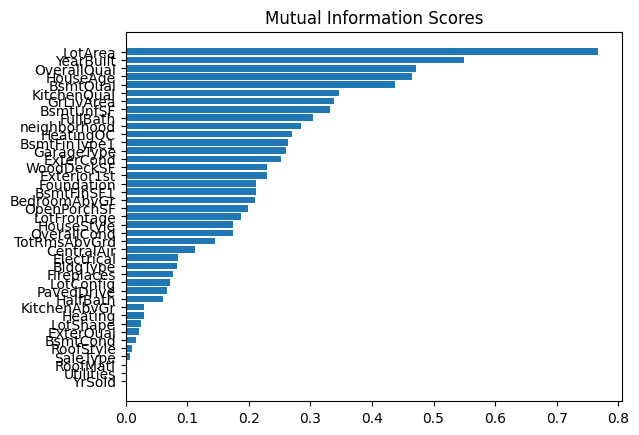

In [16]:
# scores of informative features
mi_scores = make_mi_scores(X_train, y_train)
plot_mi_scores(mi_scores)

In [17]:
# dropping features with 0.00 score - can lead to over fitting.
X_train = drop_uninformative(X_train, mi_scores)
X_test = drop_uninformative(X_test, mi_scores)

In [18]:
# define which columns should be encoded vs scaled
columns_to_scale = list(X_train.select_dtypes(include=['int64', 'float']).columns)
columns_to_encode = list(X_train.select_dtypes(include=['category']).columns)

# instantiate encoder/scaler
scaler = StandardScaler().fit(X_train[columns_to_scale])
ohe = OneHotEncoder(sparse=False).fit(X_train[columns_to_encode])

# scale and encode separate Columns
X_train_scaled_columns = scaler.transform(X_train[columns_to_scale])
X_train_encoded_columns = ohe.transform(X_train[columns_to_encode])
X_test_scaled_columns = scaler.transform(X_test[columns_to_scale])
X_test_encoded_columns = ohe.transform(X_test[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
train_processed_data = np.concatenate([X_train_scaled_columns, X_train_encoded_columns], axis=1)
test_processed_data = np.concatenate([X_test_scaled_columns, X_test_encoded_columns], axis=1)

# Assign back to X
col_lst = columns_to_scale + list(ohe.get_feature_names_out())
X_train = pd.DataFrame(train_processed_data, columns=col_lst)
X_test = pd.DataFrame(test_processed_data, columns=col_lst)

In [19]:
# save train data
X_train.to_csv(os.path.join(config['path']['train'], 'X_train.csv'), index=False)
y_train.to_csv(os.path.join(config['path']['train'], 'y_train.csv'), index=False)

# save test data
X_test.to_csv(os.path.join(config['path']['test'], 'X_test.csv'), index=False)
y_test.to_csv(os.path.join(config['path']['test'], 'y_test.csv'), index=False)